<ipython-input-1-80fe7c0090c4>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
<ipython-input-1-80fe7c0090c4>:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean().interpolate()


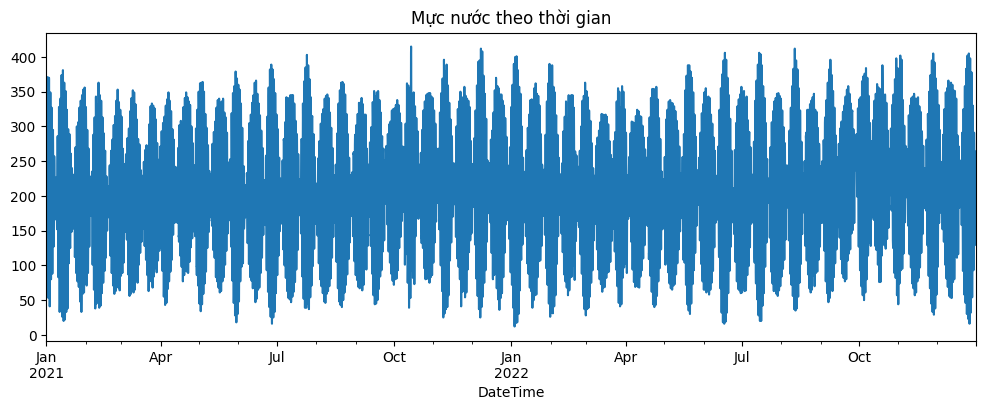

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv(
    "/content/dulieudachuanhoa.csv",
    parse_dates=["DateTime"],           # cột cần parse
    date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%Y %H:%M")  # hoặc "%m/%d/%y %H:%M"
)

df = df.set_index("DateTime")

# Kiểm tra & sắp xếp
df = df.sort_index()

# (Tùy chọn) Nếu dữ liệu chưa liên tục theo giờ, resample:
df = df.resample("1H").mean().interpolate()

# Vẽ nhanh để hình dung
df["Value(cm)"].plot(figsize=(12,4), title="Mực nước theo thời gian")
plt.show()


In [ ]:
# Chuẩn hoá về [0,1] để GRU học dễ hơn
scaler = MinMaxScaler(feature_range=(0,1))
values_scaled = scaler.fit_transform(df[["Value(cm)"]].values)

# Hàm tạo cặp (X, y) dựa trên cửa sổ trượt
def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 24*7   # số giờ quá khứ để dự đoán giờ kế tiếp
X, y = create_sequences(values_scaled, LOOK_BACK)

# Thêm chiều features cho Keras: (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

# Tách train/test (80-20)
split = int(0.8 * len(X))
X_train, X_test  = X[:split],  X[split:]
y_train, y_test  = y[:split],  y[split:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

tf.random.set_seed(42)

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    GRU(32),
    Dense(1)         # đầu ra đơn lẻ
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 168, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0250 - mae: 0.1026 - val_loss: 4.3751e-04 - val_mae: 0.0167
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0010 - mae: 0.0252 - val_loss: 5.0288e-04 - val_mae: 0.0188
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.8029e-04 - mae: 0.0207 - val_loss: 4.5341e-04 - val_mae: 0.0171
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.2454e-04 - mae: 0.0181 - val_loss: 2.5442e-04 - val_mae: 0.0126
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4.1964e-04 - mae: 0.0163 - val_loss: 3.2121e-04 - val_mae: 0.0145
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 3.6102e-04 - mae: 0.0151 - val_loss: 2.2026e-04 - val_mae: 0.0115
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.3404e-04 - mae: 0.0145 - val_loss: 2.2990e-04 - val_mae: 0.0122
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.9567e-04 - mae: 0.0135 - val_loss: 2.1701e-04 -

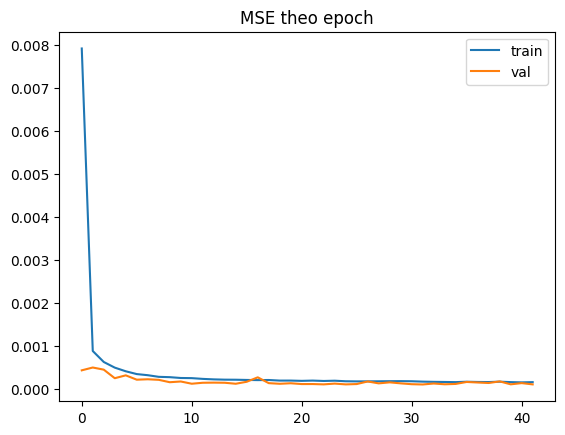

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend(); plt.title("MSE theo epoch"); plt.show()

In [ ]:
def forecast_future(model, last_window, n_steps):
    """last_window: (look_back,1) đã scale"""
    preds = []
    current_input = last_window.copy()
    for _ in range(n_steps):
        pred = model.predict(current_input[np.newaxis, ...])[0,0]
        preds.append(pred)
        # cập nhật cửa sổ
        current_input = np.roll(current_input, -1)
        current_input[-1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1))

# Lấy cửa sổ cuối cùng của toàn bộ dữ liệu
last_window = values_scaled[-LOOK_BACK:]
future_24h  = forecast_future(model, last_window, n_steps=24)
print("Dự đoán 24 giờ tới (cm):\n", future_24h.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Dự đoán 24 giờ tới (cm):
 [173.30553 175.94543 180.12325 186.82619 195.7501  205.71791 

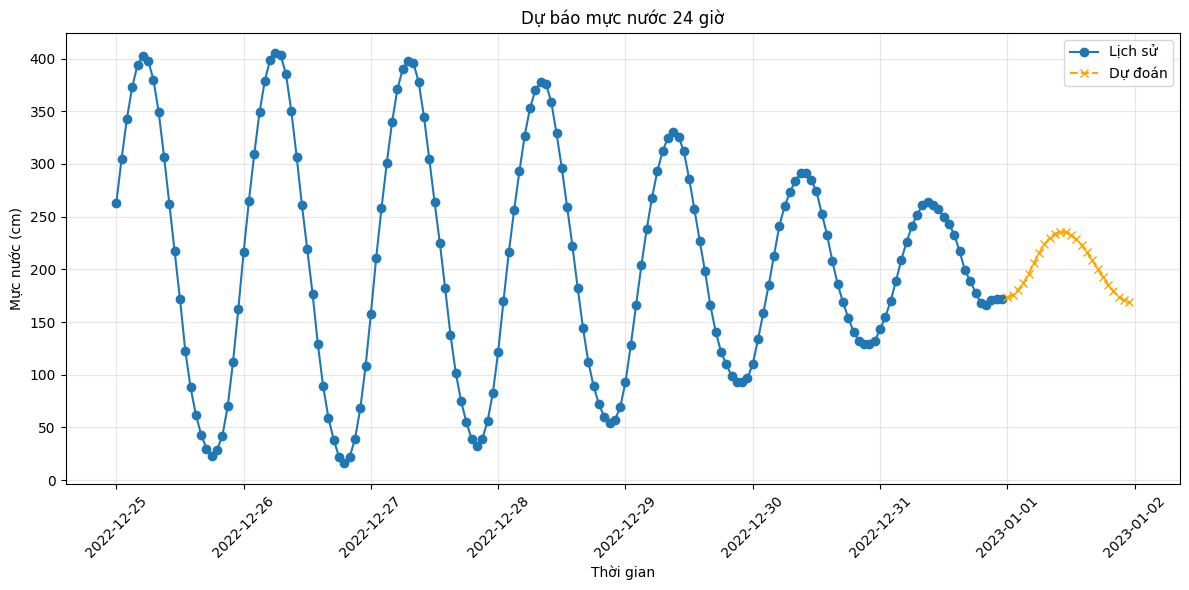

In [ ]:

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Tạo timeline
last_date = df.index[-1]
future_dates = [last_date + timedelta(hours=i+1) for i in range(24)]

plt.figure(figsize=(12, 6))

# Vẽ dữ liệu lịch sử
plt.plot(df.index[-24*7:], df['Value(cm)'][-24*7:], label='Lịch sử', marker='o')

# Vẽ dự đoán
plt.plot(future_dates, future_24h.flatten(), label='Dự đoán',
         color='orange', linestyle='--', marker='x')

plt.title('Dự báo mực nước 24 giờ')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (cm)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model.save("gru_waterlevel_model.keras")
import joblib
joblib.dump(scaler, "scaler.save")

['scaler.save']

In [ ]:
import numpy as np

def forecast_future(model, last_window, n_steps, scaler):
    """
    model       : mô hình (đã huấn luyện).
    last_window : mảng shape = (look_back, 1) – đã scale.
    n_steps     : số bước dự báo tương lai.
    scaler      : đối tượng scaler dùng lúc tiền xử lý.
    """
    preds = []
    current_input = last_window.copy()

    for _ in range(n_steps):
        # model dự đoán cho 1 bước
        pred = model.predict(current_input[np.newaxis, ...], verbose=0)[0, 0]
        preds.append(pred)

        # trượt cửa sổ: bỏ giá trị đầu, thêm giá trị mới vào cuối
        current_input = np.roll(current_input, -1)
        current_input[-1, 0] = pred

    # đảo scale về đơn vị gốc
    preds_original = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds_original


In [ ]:
def forecast_at(model, data_scaled, data_original, t_index, look_back,
                n_steps, scaler):
    """
    data_scaled    : chuỗi sau khi scale, shape = (N, 1)
    data_original  : chuỗi gốc (chưa scale), shape = (N, )
    t_index        : chỉ số thời gian muốn bắt đầu dự báo (0-based)
    """
    # Bảo đảm đủ dữ liệu quá khứ
    if t_index < look_back:
        raise ValueError("t_index phải ≥ look_back")

    # Lấy cửa sổ look_back bước trước thời điểm t
    window = data_scaled[t_index - look_back : t_index]

    # Dự báo 24 giờ tới
    preds = forecast_future(model, window, n_steps, scaler)

    # Lấy dữ liệu thực cùng khung thời gian để so sánh
    actual = data_original[t_index : t_index + n_steps]

    return preds, actual


In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(preds, actual, start_time=None, ylabel="Giá trị"):
    """
    start_time : chỉ để hiển thị trên trục x (tuple hoặc số, tuỳ bạn)
    """
    horizon = np.arange(len(preds))

    plt.figure(figsize=(10, 4))
    plt.plot(horizon, actual, label="Thực tế", linewidth=2)
    plt.plot(horizon, preds,  label="Dự báo",  linewidth=2, linestyle="--")
    plt.title("So sánh dự báo 24 giờ và dữ liệu thực")
    plt.xlabel("Giờ tới" if start_time is None else f"Ghế {start_time}+h")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


RMSE 24 giờ tại mốc t=5500: 18.562


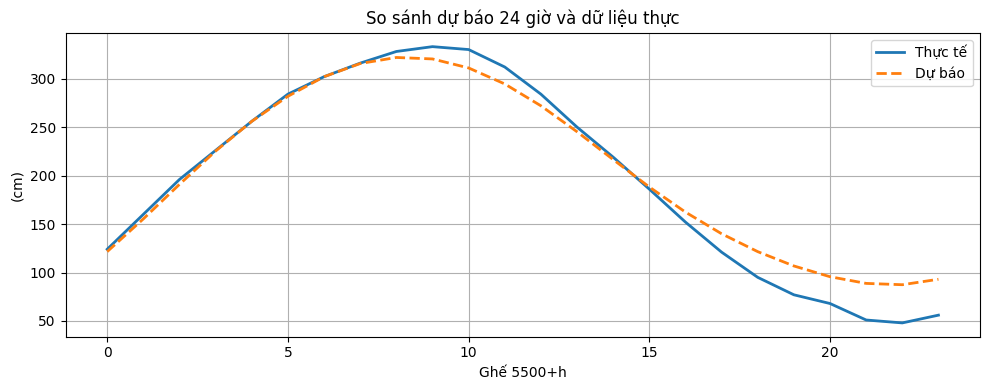

In [ ]:
LOOK_BACK = 48          # ví dụ: sử dụng 48 bước (≈ 2 ngày) làm đầu vào
N_STEPS   = 24          # dự báo 24 giờ
t = 5500                # chọn mốc thời gian bất kỳ

# Chuẩn bị dữ liệu (giả sử bạn đã có):
# - values_scaled : ndarray (N,1)
# - values        : ndarray (N, )
# - scaler        : đối tượng MinMaxScaler / StandardScaler…
# - model         : mô hình đã train

# Extract the original 'Value(cm)' data from the DataFrame
values = df['Value(cm)'].values

preds_24h, actual_24h = forecast_at(model,
                                    data_scaled   = values_scaled,
                                    data_original = values,
                                    t_index       = t,
                                    look_back     = LOOK_BACK,
                                    n_steps       = N_STEPS,
                                    scaler        = scaler)

# Tính RMSE nhanh (tùy chọn)
rmse = np.sqrt(np.mean((preds_24h - actual_24h) ** 2))
print(f"RMSE 24 giờ tại mốc t={t}: {rmse:.3f}")

# Vẽ
plot_forecast(preds_24h, actual_24h, start_time=t, ylabel="(cm)")